## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras


Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    x = Dense(units=num_neurons[0],
              activation=None,
              name='hidden_layer_0',
              kernel_regularizer=l1_l2(1e-12,1e-12))(input_layer)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    for i, neurons in enumerate(num_neurons):
        x = Dense(units=neurons,
                  activation=None,
                  name='hidden_layer_{0}'.format(str(i+1)),
                  kernel_regularizer=l1_l2(1e-12,1e-12))(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2. ,alpha=4. , a=0.3, b=0.7):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return a*tf.reduce_mean(reduced_fl) + b*keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [20]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               1573376   
_________________________________________________________________
activation_25 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               262656    
_________________________________________________________________
activation_26 (Activation)   (None, 512) 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 82us/step - loss: 3.8679 - acc: 0.2594 - val_loss: 3.6260 - val_acc: 0.3282
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.9567 - acc: 0.3554 - val_loss: 2.9500 - val_acc: 0.3489
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.7005 - acc: 0.3905 - val_loss: 2.5716 - val_acc: 0.4141
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.5625 - acc: 0.4140 - val_loss: 2.4829 - val_acc: 0.4301
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.4675 - acc: 0.4294 - val_loss: 2.4318 - val_acc: 0.4361
Epoch 6/25
50000/50000 [==============================] - 2s 42us/step - loss: 2.3867 - acc: 0.4442 - val_loss: 2.3715 - val_acc: 0.4555
Epoch 7/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.3325 - acc: 0.4527 - val_loss: 2.2877 - val_acc

Epoch 15/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.0058 - acc: 0.5182 - val_loss: 2.1006 - val_acc: 0.5046
Epoch 16/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.9633 - acc: 0.5292 - val_loss: 2.0915 - val_acc: 0.5063
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9518 - acc: 0.5282 - val_loss: 2.1011 - val_acc: 0.5071
Epoch 18/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9186 - acc: 0.5356 - val_loss: 2.0942 - val_acc: 0.5033
Epoch 19/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8949 - acc: 0.5400 - val_loss: 2.0530 - val_acc: 0.5096
Epoch 20/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8735 - acc: 0.5432 - val_loss: 2.0669 - val_acc: 0.5085
Epoch 21/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8531 - acc: 0.5475 - val_loss: 2.0705 - val_acc: 0.5090
Epoch 22/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 96us/step - loss: 3.8600 - acc: 0.2567 - val_loss: 3.5138 - val_acc: 0.3070
Epoch 2/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.9769 - acc: 0.3548 - val_loss: 2.8397 - val_acc: 0.3666
Epoch 3/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.7153 - acc: 0.3918 - val_loss: 2.5905 - val_acc: 0.4110
Epoch 4/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.5726 - acc: 0.4125 - val_loss: 2.4843 - val_acc: 0.4284
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.4774 - acc: 0.4315 - val_loss: 2.4261 - val_acc: 0.4398
Epoch 6/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.3861 - acc: 0.4433 - val_loss: 2.3776 - val_acc: 0.4493
Epoch 7/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.3225 - acc: 0.4551 - val_loss: 2.3277 - val_acc

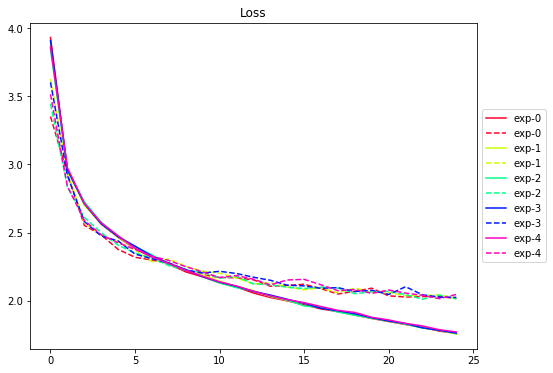

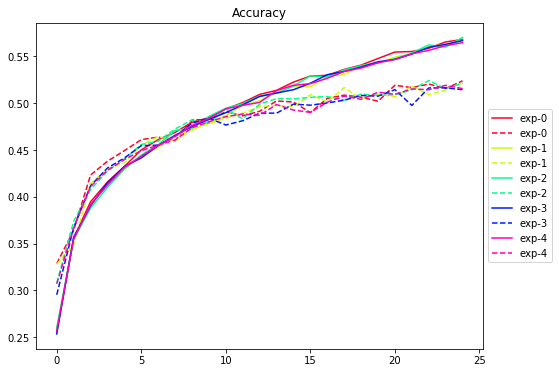

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()